<a href="https://colab.research.google.com/github/ashishagg70/GANText2Image/blob/master/Text2FaceV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown --id 1D4yFM5bLF2PEVlM_yXzTp-cLjGgNai2m
#!gdown --id 1UQNd2OsbuuW5QSfc6-78e0heJk3F3FeL
#!gdown --id 14a90ceynctKczgase-iVbS8ZbwcTZSOT
#!gdown --id 1d1Cfsz1BcdWE_b4eF8KG6tSa0efsKLZ0
!gdown --id 19DTv9tXIby7FW8TnU69u8xbNpcTWx6RG

Downloading...
From: https://drive.google.com/uc?id=1D4yFM5bLF2PEVlM_yXzTp-cLjGgNai2m
To: /content/img_align_celeba.zip
1.44GB [00:10, 132MB/s]
Downloading...
From: https://drive.google.com/uc?id=19DTv9tXIby7FW8TnU69u8xbNpcTWx6RG
To: /content/list_attr_celeba.csv.zip
2.12MB [00:00, 33.5MB/s]


In [2]:
!unzip img_align_celeba.zip
!unzip list_attr_celeba.csv.zip
#!unzip list_bbox_celeba.csv.zip
#!unzip list_eval_partition.csv.zip
#!unzip list_landmarks_align_celeba.csv.zip

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 extracting: img_align_celeba/197622.jpg  
 extracting: img_align_celeba/197623.jpg  
 ex

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torchvision import datasets, transforms
from PIL import Image
from torchvision.transforms import ToPILImage

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

cuda


In [20]:
list_attr_celeba_test = pd.read_csv("list_attr_celeba.csv")
#list_attr_celeba_test.head(10)
attributes_test = list_attr_celeba_test.iloc[:,1:].values
attributes_test[attributes_test<0]=0
attributes_test

array([[0, 1, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1]])

In [131]:
image_dir='./img_align_celeba/'
features=40
z_features = 200
batch = 7500
imagePixel=128

In [132]:
transform = transforms.Compose([transforms.Resize(imagePixel),
                                transforms.CenterCrop(imagePixel),
                                transforms.ToTensor()])

In [133]:
images_attr_data = []
list_attr_celeba = pd.read_csv("list_attr_celeba.csv")
for i in range(1,batch):
  fileInd=i
  attributeInd=i-1
  filename = "{}{:06d}.jpg".format(image_dir,fileInd)
  image = Image.open(filename)
  x = transform(image).numpy()
  attributes=list_attr_celeba.iloc[attributeInd].to_numpy().squeeze()[1:].astype('float32')
  attributes[attributes<0]=0
  images_attr_data.append((x,attributes))

In [134]:
def collate_fn(data):
  imgs = list(map(lambda i: images_attr_data[i][0],data))
  attrs= list(map(lambda i: images_attr_data[i][1],data))
  l = len(data)
  
  imgs = torch.tensor(imgs).to(device)
  attrs = torch.tensor(attrs)
  z= torch.randn((l,z_features))
  attrs_with_noise = torch.hstack((z,attrs))
  attrs_with_noise = attrs_with_noise.to(device)
  attrs = attrs.to(device)
  return imgs,attrs,attrs_with_noise

In [135]:
train_loader = torch.utils.data.DataLoader(
    range(batch-1),
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [136]:
cout=128

In [167]:
class nn_G(nn.Module):
    def __init__(self):
      super().__init__()
      self.linear1 = nn.Linear(features+z_features, cout*128)

      self.conv1 = nn.ConvTranspose2d(cout*8,cout*4,4,stride=2, padding=1)
      self.bnorm1 = nn.BatchNorm2d(cout*4)

      self.conv2 = nn.ConvTranspose2d(cout*4,cout*2,4,stride=2, padding=1)
      self.bnorm2 = nn.BatchNorm2d(cout*2)
      self.conv3 = nn.ConvTranspose2d(cout*2,cout,4,stride=2, padding=1)
      self.bnorm3 = nn.BatchNorm2d(cout)
      self.conv4 = nn.ConvTranspose2d(cout,cout//2,4,stride=2, padding=1)

      self.bnorm4 = nn.BatchNorm2d(cout//2)
      self.conv5 = nn.ConvTranspose2d(cout//2,3,4,stride=2, padding=1)
      #self.bnorm4 = nn.BatchNorm2d(3)
      


    def forward(self,x):
      #print("gen start",x.shape)

      x = self.linear1(x)
      #print("lin",x.shape)

      x = x.reshape((len(x),cout*8,4,4))
      #print("reshape",x.shape)

      x = self.conv1(x)
      x = self.bnorm1(x)
      x = nn.LeakyReLU()(x)
      #print("conv1",x.shape)

      x = self.conv2(x)
      x = self.bnorm2(x)
      x = nn.LeakyReLU()(x)
      #print("conv2",x.shape)

      x = self.conv3(x)
      x = self.bnorm3(x)
      x = nn.LeakyReLU()(x)
      #print("conv3",x.shape)

      #for 128 pixel image
      x = self.conv4(x)
      x = self.bnorm4(x)
      x = nn.LeakyReLU()(x)

      x = self.conv5(x)
      #print("conv4",x.shape)

      #x = self.bnorm2(x)
      x = nn.Tanh()(x)
      #print("tanh",x.shape)


      return x


In [197]:
class nn_D(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv0 = nn.Conv2d(3,cout//2,4,stride=2, padding=1)
      self.bnorm0 = nn.BatchNorm2d(cout//2)

      self.conv1 = nn.Conv2d(cout//2,cout,4,stride=2, padding=1)
      self.bnorm1 = nn.BatchNorm2d(cout)

      self.conv2 = nn.Conv2d(cout,cout*2,4,stride=2, padding=1)
      self.bnorm2 = nn.BatchNorm2d(cout*2)
      self.conv3 = nn.Conv2d(cout*2,cout*4,4,stride=2, padding=1)
      self.bnorm3 = nn.BatchNorm2d(cout*4)
      self.conv4 = nn.Conv2d(cout*4,cout*8,4,stride=2, padding=1)
      self.bnorm4 = nn.BatchNorm2d(cout*8)
      self.lineart = nn.Linear(features,features*4*4)
      self.conv5 = nn.Conv2d(cout*8+features,1,4)
      self.linear = nn.Linear((cout*8+features)*4*4,1)

    def forward(self,x,t):
      #print("dis start",x.shape, t.shape)

      x = self.conv0(x)
      #print("conv1",x.shape)
      x = self.bnorm0(x)
      x = nn.LeakyReLU()(x)

      x = self.conv1(x)
      #print("conv1",x.shape)
      x = self.bnorm1(x)
      x = nn.LeakyReLU()(x)

      x = self.conv2(x)
      #print("conv2",x.shape)
      x = self.bnorm2(x)
      x = nn.LeakyReLU()(x)
      
      x = self.conv3(x)
      #print("conv3",x.shape)
      x = self.bnorm3(x)
      x = nn.LeakyReLU()(x)
      

      x = self.conv4(x)
      #print("conv4",x.shape)
      x = self.bnorm4(x)
      x = nn.LeakyReLU()(x)

      t1=self.lineart(t)
      t = t1.reshape((t.shape[0],t.shape[1],4,4))
      #print("stack t",t.shape)

      #print(x.shape, t.shape)
      x = torch.cat((x,t),dim=1)
      #print(x.size())
      #print("merge",x.shape)
      x=torch.flatten(x, start_dim=1)
      #x = x.reshape((t.shape[0],(cout*8+features)*4*4))
      #print(x.size())
      x=self.linear(x)
      #x = self.conv5(x)
      #print("conv5",x.shape)

      x=x.squeeze()
      x = nn.Sigmoid()(x)
      #print("final",x.shape)

      return x


In [198]:
nn_Gen = nn_G().to(device)
nn_Dis = nn_D().to(device)

In [199]:

epochs = 200

learning_rate_dis = 0.0001
learning_rate_gen=0.0001*2

optimizer_gen = torch.optim.Adam(nn_Gen.parameters(),lr=learning_rate_gen,betas=(0.5,0.9))

optimizer_dis = torch.optim.Adam(nn_Dis.parameters(),lr=learning_rate_dis,betas=(0.5,0.9))

criterion = nn.BCELoss(reduction='mean')

real_label = 0.9
fake_label = 0.1


In [200]:

for epoch in range(epochs):
    for batch_idx, _data in enumerate(train_loader):
      _imgs, _attrs,  _attrs_with_noise= _data
      optimizer_dis.zero_grad()
      out_real = nn_Dis(_imgs,_attrs)
      l = len(_attrs)
      real_tensor = torch.tensor([real_label]*l,dtype=torch.float).to(device)
      fake_tensor = torch.tensor([fake_label]*l,dtype=torch.float).to(device)

      if(batch_idx%3!=0):
        loss_real = criterion(out_real,real_tensor)
      else:
        loss_real = criterion(out_real,fake_tensor)
      loss_real.backward()

      out_fake = nn_Dis(nn_Gen(_attrs_with_noise),_attrs)
      if(batch_idx%3!=0):
        loss_fake = criterion(out_fake,fake_tensor)
      else:
        loss_fake = criterion(out_fake,real_tensor)
        
      loss_fake.backward()
      optimizer_dis.step()
      
      optimizer_gen.zero_grad()
      out_fake2 = nn_Dis(nn_Gen(_attrs_with_noise),_attrs)
      loss_gen = criterion(out_fake2,real_tensor)
      loss_gen.backward()
      optimizer_gen.step()
    print("{}, out_real={},out_fake={},out_fake2={},loss_real={},loss_fake={},loss_gen={}".format(epoch, out_real.mean().item(),out_fake.mean().item(),out_fake2.mean().item(),loss_real.item(),loss_fake.item(),loss_gen.item()))

    gen_z= torch.rand(z_features)
    gen_attr = torch.tensor(attributes_test[100])
    gen_input = torch.cat((gen_attr,gen_z)).unsqueeze(dim=0).to(device)
    gen = nn_Gen(gen_input)
    gen = gen.squeeze(0)
    img = ToPILImage()(gen.cpu())
    img.save('./gen/{}.jpg'.format(epoch))



0, out_real=0.5010858178138733,out_fake=0.28716933727264404,out_fake2=0.5335254073143005,loss_real=0.6977906227111816,loss_fake=1.179807186126709,loss_gen=0.6507951021194458
1, out_real=0.5440424084663391,out_fake=0.4508218765258789,out_fake2=0.5248913168907166,loss_real=0.7694859504699707,loss_fake=0.7815225124359131,loss_gen=0.6596579551696777
2, out_real=0.5004616975784302,out_fake=0.39689549803733826,out_fake2=0.6001182198524475,loss_real=0.6977526545524597,loss_fake=0.896761417388916,loss_gen=0.5528188943862915
3, out_real=0.5136346817016602,out_fake=0.5155072808265686,out_fake2=0.5232596397399902,loss_real=0.7161457538604736,loss_fake=0.6695850491523743,loss_gen=0.6603407859802246
4, out_real=0.4627065062522888,out_fake=0.46571993827819824,out_fake2=0.47297948598861694,loss_real=0.6409894227981567,loss_fake=0.7520911693572998,loss_gen=0.7381995916366577
5, out_real=0.4613184630870819,out_fake=0.4806828200817108,out_fake2=0.4870108962059021,loss_real=0.6392548680305481,loss_fake=0

KeyboardInterrupt: ignored

In [87]:
z= torch.randn(z_features)
attr = torch.tensor(attributes_test[400])
gen_input = torch.cat((attr,z)).unsqueeze(0).to(device)
x = nn_Gen(gen_input)
x = x.squeeze(0)

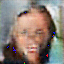

In [88]:
img = ToPILImage()(x.cpu())
img

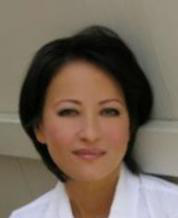

In [68]:
filename = "{}{:06d}.jpg".format(image_dir,101)
image = Image.open(filename)
image

In [ ]:
x = transform2(image)
print(x.shape)
img = ToPILImage()(x.cpu())
img

In [ ]:
transform2 = transforms.Compose([transforms.Resize(64),
                                 transforms.CenterCrop(64),
                                transforms.ToTensor()])

In [ ]:
attributes_test[171]

In [ ]:
x = transforms.functional.to_tensor(image)
print(x.shape)
img = ToPILImage()(x.cpu())
img

In [ ]:
#pd.set_option("display.max_columns",None)
#print(list_attr_celeba.head(11))
list_attr_celeba.iloc[0].to_numpy()


References:\
1. https://www.kaggle.com/jessicali9530/celeba-dataset?select=list_attr_celeba.csv \
2. 